## Introduction

### This notebook use PointNet to perform 3D Object Classification on ModelNet10 Dataset.

### Libraries

In [1]:
import os
import numpy as np
import itertools
import math, random
random.seed = 42

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from path import Path
import scipy.spatial.distance
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
path = Path("../input/modelnet10-princeton-3d-object-dataset/ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};
classes

{'bathtub': 0,
 'bed': 1,
 'chair': 2,
 'desk': 3,
 'dresser': 4,
 'monitor': 5,
 'night_stand': 6,
 'sofa': 7,
 'table': 8,
 'toilet': 9}

### Utility Functions

In [ ]:
def load_off_data(file_obj):
    header_line = file_obj.readline().strip()
    if header_line != "OFF":
        raise ValueError("Not a valid OFF header")
    counts = file_obj.readline().strip().split()
    num_vertices, num_faces = int(counts[0]), int(counts[1])
    vertices = []
    for _ in range(num_vertices):
        vertex_vals = file_obj.readline().strip().split()
        vertices.append([float(val) for val in vertex_vals])
    facets = []
    for _ in range(num_faces):
        facet_vals = file_obj.readline().strip().split()
        facets.append([int(val) for val in facet_vals[1:]])
    return vertices, facets


def create_rotating_figure(plot_data):
    eye_x, eye_y, eye_z = 1.25, 1.25, 0.8
    frame_list = []

    def rotate_about_z(x, y, z, angle):
        complex_coord = x + 1j * y
        rotated = np.exp(1j * angle) * complex_coord
        return np.real(rotated), np.imag(rotated), z

    for t in np.arange(0, 10.26, 0.1):
        ex, ey, ez = rotate_about_z(eye_x, eye_y, eye_z, -t)
        frame_list.append({
            "layout": {
                "scene": {
                    "camera": {"eye": {"x": ex, "y": ey, "z": ez}}
                }
            }
        })

    fig = go.Figure(
        data=plot_data,
        layout=go.Layout(
            updatemenus=[{
                "type": "buttons",
                "showactive": False,
                "y": 1,
                "x": 0.8,
                "xanchor": "left",
                "yanchor": "bottom",
                "pad": {"t": 45, "r": 10},
                "buttons": [{
                    "label": "Play",
                    "method": "animate",
                    "args": [None, {
                        "frame": {"duration": 50, "redraw": True},
                        "transition": {"duration": 0},
                        "fromcurrent": True,
                        "mode": "immediate"
                    }]
                }]
            }]
        ),
        frames=frame_list
    )
    return fig


# 从OFF文件中读取数据
with open(path / "sofa/train/sofa_0002.off", 'r') as off_file:
    vertices, facets = load_off_data(off_file)

# 转置facets与vertices，便于后续处理
i_vals, j_vals, k_vals = np.array(facets).T
x_coords, y_coords, z_coords = np.array(vertices).T
print(len(x_coords))


class MeshPointSampler:
    def __init__(self, num_samples):
        assert isinstance(num_samples, int)
        self.num_samples = num_samples

    def compute_triangle_area(self, pt1, pt2, pt3):
        edge1 = np.linalg.norm(pt1 - pt2)
        edge2 = np.linalg.norm(pt2 - pt3)
        edge3 = np.linalg.norm(pt3 - pt1)
        s = 0.5 * (edge1 + edge2 + edge3)
        return max(s * (s - edge1) * (s - edge2) * (s - edge3), 0) ** 0.5

    def sample_from_triangle(self, pt1, pt2, pt3):
        # 通过重排序随机数生成重心坐标
        r1, r2 = sorted([random.random(), random.random()])
        sample_val = lambda idx: r1 * pt1[idx] + (r2 - r1) * pt2[idx] + (1 - r2) * pt3[idx]
        return (sample_val(0), sample_val(1), sample_val(2))

    def __call__(self, mesh):
        verts, face_list = mesh
        verts = np.array(verts)
        area_array = np.zeros(len(face_list))
        for idx, face in enumerate(face_list):
            area_array[idx] = self.compute_triangle_area(
                verts[face[0]], verts[face[1]], verts[face[2]]
            )
        selected_faces = random.choices(face_list, weights=area_array, k=self.num_samples)
        sampled_points = np.zeros((self.num_samples, 3))
        for i, face in enumerate(selected_faces):
            sampled_points[i] = self.sample_from_triangle(
                verts[face[0]], verts[face[1]], verts[face[2]]
            )
        return sampled_points


sampled_point_cloud = MeshPointSampler(3000)((vertices, facets))


class PointCloudNormalizer:
    def __call__(self, pc):
        assert pc.ndim == 2
        centered_pc = pc - np.mean(pc, axis=0)
        max_norm = np.max(np.linalg.norm(centered_pc, axis=1))
        return centered_pc / max_norm


normalized_pc = PointCloudNormalizer()(sampled_point_cloud)


class RandomZRotation:
    def __call__(self, pc):
        assert pc.ndim == 2
        theta = random.random() * 2 * math.pi
        rot_matrix = np.array([
            [math.cos(theta), -math.sin(theta), 0],
            [math.sin(theta),  math.cos(theta), 0],
            [0, 0, 1]
        ])
        return (rot_matrix @ pc.T).T


rotated_pc = RandomZRotation()(normalized_pc)


class AddRandomNoise:
    def __call__(self, pc):
        assert pc.ndim == 2
        noise = np.random.normal(loc=0, scale=0.02, size=pc.shape)
        return pc + noise


noisy_rotated_pc = AddRandomNoise()(rotated_pc)


class ToTensorConverter:
    def __call__(self, pc):
        assert pc.ndim == 2
        return torch.from_numpy(pc)


def default_transformation_pipeline():
    return transforms.Compose([
        MeshPointSampler(1024),
        PointCloudNormalizer(),
        ToTensorConverter()
    ])

### Define Datasets / Dataloaders

In [ ]:
class PCDataset(Dataset):
    def __init__(self, base_dir, is_valid=False, subset="train", transform=default_transforms()):
        """
        参数：
            base_dir: 数据根目录，应为 Path 对象
            is_valid: 是否为验证集（True 表示验证集，此时强制使用默认数据预处理）
            subset: 指定子文件夹名称，默认为 "train"，验证集时一般为 "test"
            transform: 数据预处理流程
        """
        self.base_dir = base_dir
        # 从根目录中获取所有类别文件夹
        class_folders = [entry for entry in sorted(os.listdir(base_dir)) if os.path.isdir(base_dir / entry)]
        self.class_to_idx = {cls: idx for idx, cls in enumerate(class_folders)}
        # 验证集时始终使用默认变换，否则使用传入的 transform
        self.transform = default_transforms() if is_valid else transform
        self.is_valid = is_valid
        self.samples = []

        # 遍历每个类别文件夹下的子目录（train 或 test），收集所有.off文件的路径
        for cls in self.class_to_idx.keys():
            current_folder = base_dir / Path(cls) / subset
            for fname in os.listdir(current_folder):
                if fname.endswith('.off'):
                    sample_info = {
                        "pcd_path": current_folder / fname,
                        "category": cls
                    }
                    self.samples.append(sample_info)

    def __len__(self):
        return len(self.samples)

    def _process_off(self, file_obj):
        verts, faces = read_off(file_obj)
        if self.transform:
            pc_data = self.transform((verts, faces))
        else:
            pc_data = (verts, faces)
        return pc_data

    def __getitem__(self, idx):
        sample = self.samples[idx]
        file_path = sample['pcd_path']
        label = sample['category']
        with open(file_path, 'r') as f:
            point_cloud = self._process_off(f)
        return {'pointcloud': point_cloud, 
                'category': self.class_to_idx[label]}


# 定义数据预处理流程
custom_transforms = transforms.Compose([
    PointSampler(1024),
    Normalize(),
    RandRotation_z(),
    RandomNoise(),
    ToTensor()
])

# 实例化训练和验证数据集
train_ds = PCDataset(path, is_valid=False, subset="train", transform=custom_transforms)
valid_ds = PCDataset(path, is_valid=True, subset="test", transform=custom_transforms)

inv_classes = {idx: cls for cls, idx in train_ds.class_to_idx.items()}

# 构造数据加载器
train_loader = DataLoader(dataset=train_ds, batch_size=32, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=64)

In [19]:
inv_classes = {i: cat for cat, i in train_ds.classes.items()};
inv_classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [20]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[0]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


### Model Definition

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, input):
        # input.shape == (bs,n,3)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

    def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [25]:
pointnet = PointNet()
pointnet.to(device);

# Load a pre-trained model if it exists
pointnet.load_state_dict(torch.load('../input/pointnet-for-3d-object-classification-pytorch/save.pth'))

<All keys matched successfully>

In [26]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.00025)

### Train PointNet

In [27]:
from tqdm import tqdm
import torch

def train(model, train_loader, val_loader=None, epochs=10):
    # 训练过程
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0

        # 使用 tqdm 显示训练进度条
        with tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            for i, data in pbar:
                inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                optimizer.zero_grad()
                outputs, m3x3, m64x64 = pointnet(inputs.transpose(1, 2))

                loss = pointnetloss(outputs, labels, m3x3, m64x64)
                loss.backward()
                optimizer.step()

                # 更新损失
                running_loss += loss.item()

                # 更新显示的进度条信息
                if (i + 1) % 5 == 0:  # 每5个batch显示一次
                    pbar.set_postfix(loss=running_loss / 5)
                    running_loss = 0.0

        # 验证过程
        if val_loader:
            pointnet.eval()
            correct = total = 0
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1, 2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print(f'Valid accuracy: {val_acc:.2f} %')

        # 保存模型
        torch.save(pointnet.state_dict(), "save.pth")

In [28]:
train(pointnet, train_loader, valid_loader)

Epoch 1/10: 100%|██████████| 125/125 [18:11<00:00,  8.73s/it, loss=0.345]


Valid accuracy: 85.35 %


Epoch 2/10: 100%|██████████| 125/125 [17:41<00:00,  8.49s/it, loss=0.263]


Valid accuracy: 86.23 %


Epoch 3/10: 100%|██████████| 125/125 [17:27<00:00,  8.38s/it, loss=0.312]


Valid accuracy: 89.98 %


Epoch 4/10: 100%|██████████| 125/125 [17:40<00:00,  8.49s/it, loss=0.234]


Valid accuracy: 87.56 %


Epoch 5/10: 100%|██████████| 125/125 [17:27<00:00,  8.38s/it, loss=0.255]


Valid accuracy: 88.88 %


Epoch 6/10: 100%|██████████| 125/125 [17:34<00:00,  8.44s/it, loss=0.229]


Valid accuracy: 85.68 %


Epoch 7/10: 100%|██████████| 125/125 [17:26<00:00,  8.37s/it, loss=0.337]


Valid accuracy: 83.48 %


Epoch 8/10: 100%|██████████| 125/125 [17:30<00:00,  8.41s/it, loss=0.288]


Valid accuracy: 87.56 %


Epoch 9/10: 100%|██████████| 125/125 [17:34<00:00,  8.44s/it, loss=0.367]


Valid accuracy: 87.11 %


Epoch 10/10: 100%|██████████| 125/125 [17:29<00:00,  8.39s/it, loss=0.269]


Valid accuracy: 89.21 %


### Test PointNet

In [29]:
all_preds = []  # 初始化all_preds为空列表
all_labels = []  # 初始化all_labels为空列表

with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))

        inputs, labels = data['pointcloud'].float().to(device), data['category'].to(device)  # 将输入数据移动到相同设备
        outputs, __, __ = pointnet(inputs.transpose(1, 2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.cpu().numpy())  # 将结果移动到 CPU
        all_labels += list(labels.cpu().numpy())  # 将标签移动到 CPU


Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]


In [30]:
cm = confusion_matrix(all_labels, all_preds)

In [31]:
# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


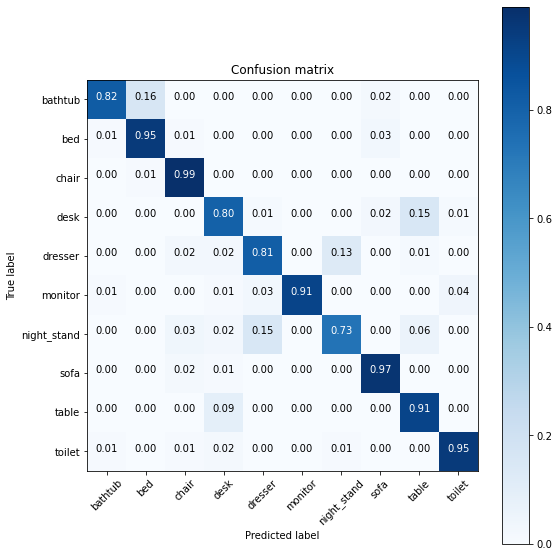

In [32]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

In [33]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

Confusion matrix, without normalization


In [34]:
from sklearn.metrics import confusion_matrix
import numpy as np

# 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 提取对角线上的正确预测数
correct_predictions = np.trace(cm)

# 计算总样本数
total_samples = cm.sum()

# 计算正确率
accuracy = correct_predictions / total_samples

print(f'Overall accuracy: {accuracy * 100:.2f}%')

Overall accuracy: 89.32%
